In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
! pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
transform=transforms.ToTensor()

mnist_data=datasets.MNIST(root='./data',train=True,download=True,transform=transform)
dataloader=DataLoader(dataset=mnist_data,batch_size=64,shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.06MB/s]


In [5]:
for(img,label) in dataloader:
    print(label)
    break

tensor([3, 2, 9, 9, 7, 6, 1, 2, 6, 9, 6, 4, 8, 3, 5, 3, 1, 2, 5, 6, 9, 8, 6, 4,
        9, 7, 0, 5, 1, 5, 2, 2, 9, 1, 0, 4, 8, 5, 7, 1, 0, 2, 0, 6, 1, 7, 9, 3,
        3, 1, 4, 2, 3, 8, 1, 3, 1, 6, 1, 6, 0, 0, 2, 4])


In [6]:
class vae(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Linear(784,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU()
        )
        self.mu=nn.Linear(64,12)
        self.logvar=nn.Linear(64,12)

        self.decoder=nn.Sequential(
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,784),
            nn.Sigmoid()
        )
    def reparametrize(self,mu,logvar):
        lv=torch.exp(0.5*logvar)
        e=torch.rand_like(lv)
        z=mu+(e*lv)
        return z
    def forward(self,x):
        out=self.encoder(x)
        mean=self.mu(out)
        std=self.logvar(out)
        z=self.reparametrize(mean,std)
        out=self.decoder(z)
        return out,mean,std

In [7]:
criterion=nn.BCELoss()

In [8]:
bce_loss = nn.BCELoss(reduction='sum')
def loss(recon,y,mean,log_var):
    bce=bce_loss(recon,y)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return bce+KLD

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
model=vae().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
epochs=30

In [11]:
for epoch in range(epochs):
    total_loss=0
    for(img,_) in dataloader:
        img=img.reshape(-1,28*28)
        img=img.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(img)
        model_loss=loss(recon,img,mu,logvar)
        model_loss.backward()
        optimizer.step()
        total_loss += model_loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader.dataset):.4f}")

Epoch 1, Loss: 212.6962
Epoch 2, Loss: 163.2651
Epoch 3, Loss: 142.5361
Epoch 4, Loss: 130.3078
Epoch 5, Loss: 124.0245
Epoch 6, Loss: 119.1515
Epoch 7, Loss: 115.9427
Epoch 8, Loss: 113.2707
Epoch 9, Loss: 110.9824
Epoch 10, Loss: 109.2466
Epoch 11, Loss: 107.8011
Epoch 12, Loss: 106.5552
Epoch 13, Loss: 105.4462
Epoch 14, Loss: 104.3286
Epoch 15, Loss: 103.1618
Epoch 16, Loss: 101.9857
Epoch 17, Loss: 100.9915
Epoch 18, Loss: 100.0972
Epoch 19, Loss: 99.2928
Epoch 20, Loss: 98.5988
Epoch 21, Loss: 97.9476
Epoch 22, Loss: 97.3152
Epoch 23, Loss: 96.7975
Epoch 24, Loss: 96.2864
Epoch 25, Loss: 95.8016
Epoch 26, Loss: 95.3879
Epoch 27, Loss: 95.0114
Epoch 28, Loss: 94.6202
Epoch 29, Loss: 94.2696
Epoch 30, Loss: 93.9043


In [12]:
import matplotlib.pyplot as plt


In [13]:
mnist_test_data=datasets.MNIST(root='./data',train=False,download=True,transform=transform)
test_loader=DataLoader(dataset=mnist_data,batch_size=64,shuffle=True)

In [14]:
model.eval()
with torch.no_grad():
    for (img,_) in test_loader:
        img=img.reshape(-1,28*28)
        img=img.to(device)
        x_hat,_,_=model(img)
        break
        

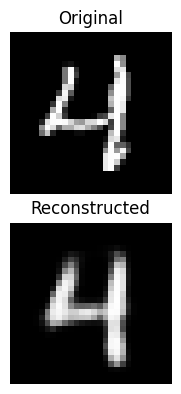

In [15]:

original = img.cpu().view(-1, 28, 28)
reconstructed = x_hat.cpu().view(-1, 28, 28)

n = 8
plt.figure(figsize=(16, 4))

for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i], cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
    break

plt.tight_layout()
plt.show()


In [16]:
from torchvision.utils import save_image, make_grid
with torch.no_grad():
    noise = torch.randn(64, 12).to(device)
    generated_images = model.decoder(noise)

In [17]:
save_image(generated_images.view(64, 1, 28, 28), 'generated_sample.png')


In [18]:
def show_image(x, idx):
    x = x.view(64, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())


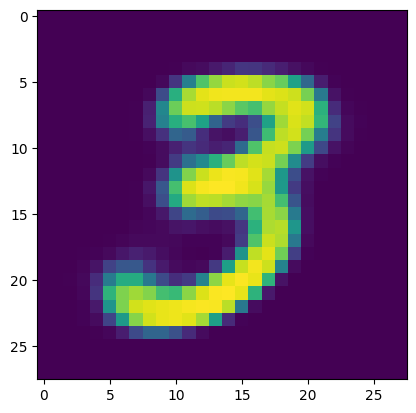

In [19]:
show_image(generated_images, idx=1)


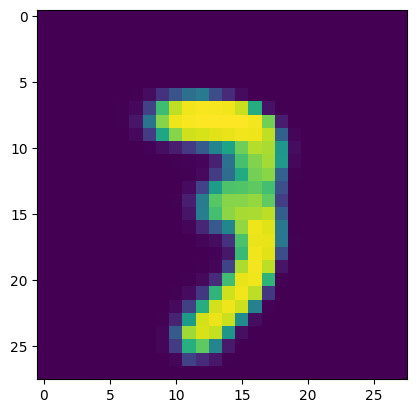

In [20]:
show_image(generated_images, idx=2)


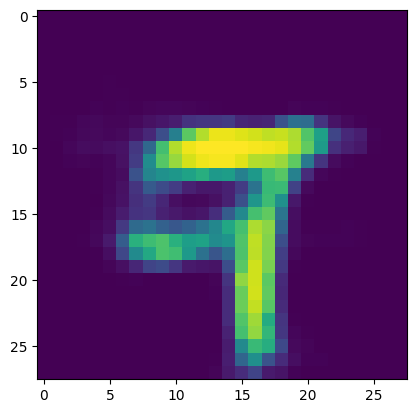

In [21]:
show_image(generated_images, idx=3)


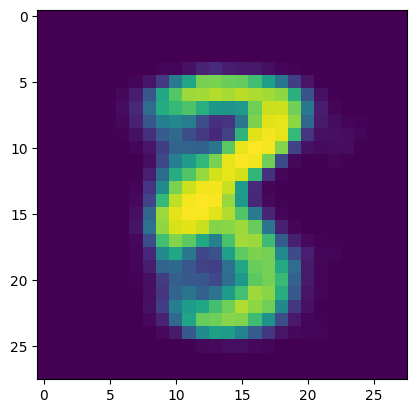

In [22]:
show_image(generated_images, idx=4)


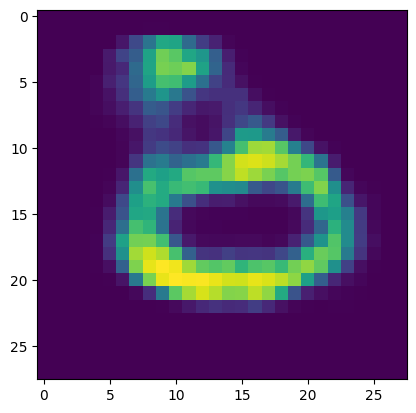

In [23]:
show_image(generated_images, idx=5)


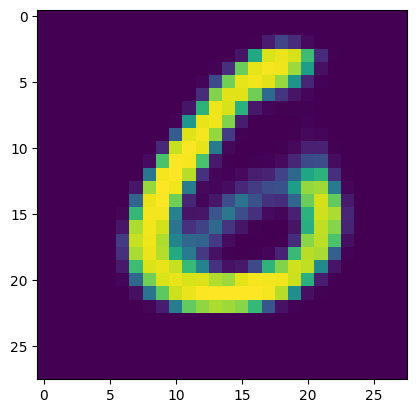

In [24]:
show_image(generated_images, idx=6)


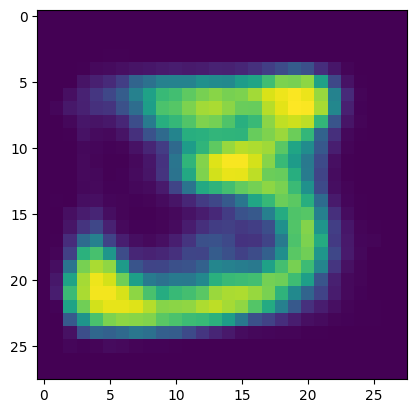

In [25]:
show_image(generated_images, idx=7)


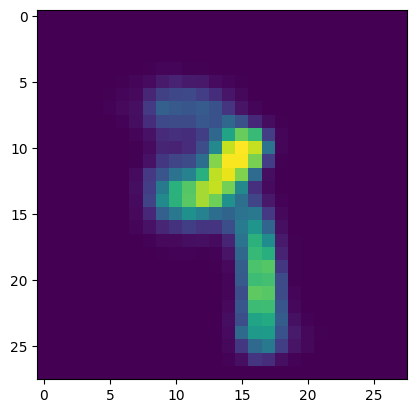

In [26]:
show_image(generated_images, idx=8)


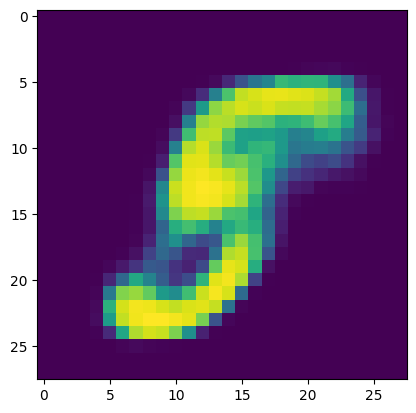

In [27]:
show_image(generated_images, idx=9)


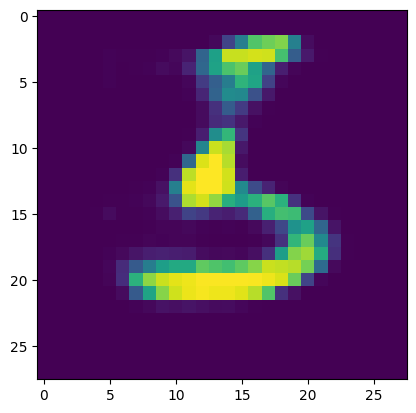

In [28]:
show_image(generated_images, idx=10)


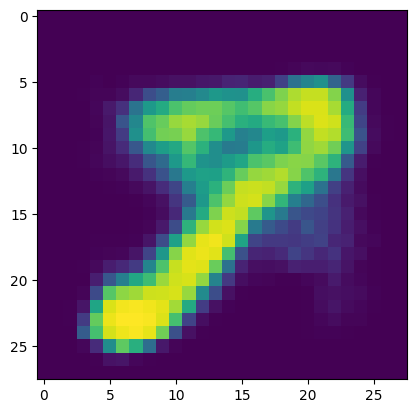

In [29]:
show_image(generated_images, idx=11)


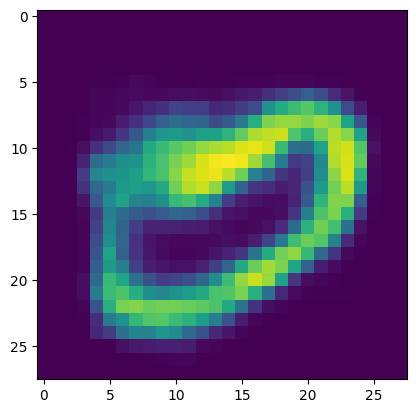

In [30]:
show_image(generated_images, idx=12)


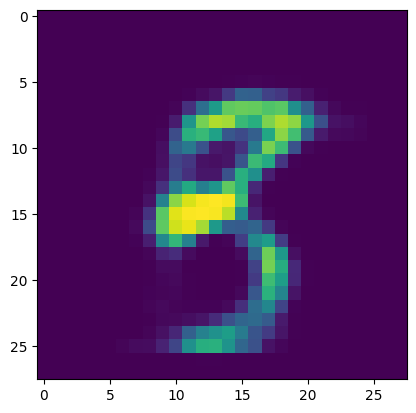

In [31]:
show_image(generated_images, idx=13)
